<a href="https://colab.research.google.com/github/ghubnerr/andrej-karpathy-course/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

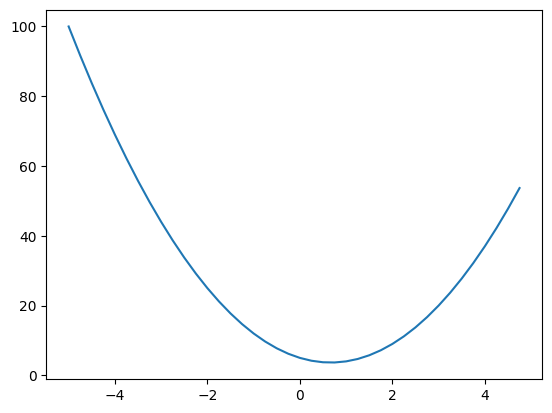

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys
plt.plot(xs, ys)

In [ ]:
h = 1e-11
x = 3.0
(f(x + h) - f(x))/h  # numerical approx of the slope

14.000178794049134

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 1e-4

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h

d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes ,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
              edges.add((child, v))
              build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
          dot.node(name = uid + n._op, label = n._op)
          dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot. edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

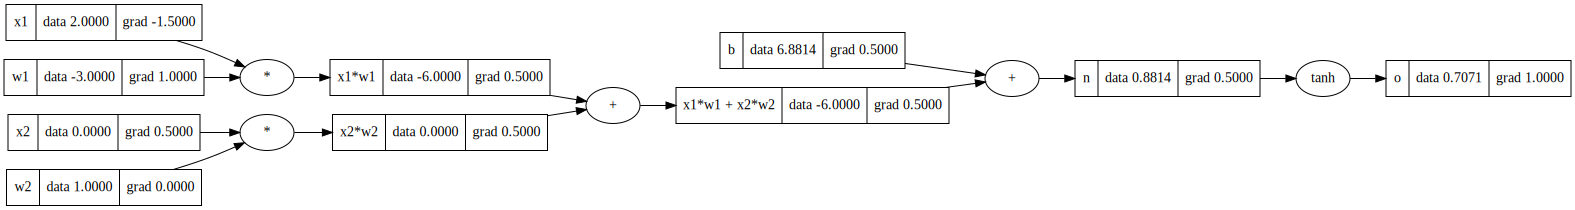

In [ ]:
o.backward()
draw_dot(o)

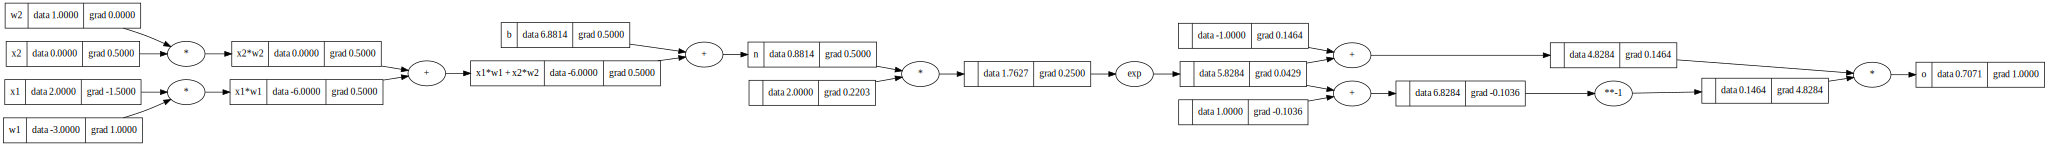

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([2.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([2.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([2.0]).double() ; w2.requires_grad = True
b = torch.Tensor([-3.0]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.9999092042625951
----
x2 0.00036316646188770533
w2 0.00036316646188770533
x1 0.00036316646188770533
w1 0.00036316646188770533


In [ ]:
import random

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7640514914414728)

In [ ]:
n.parameters()

[Value(data=0.5961431679829243),
 Value(data=0.789454204164963),
 Value(data=0.23098177300728162),
 Value(data=0.809386540708158),
 Value(data=-0.2638289592610157),
 Value(data=0.42121933734465133),
 Value(data=0.9941837219426444),
 Value(data=0.7663366972875796),
 Value(data=-0.8821144279043864),
 Value(data=0.9482613024405926),
 Value(data=0.07263505327144903),
 Value(data=-0.5477608811489028),
 Value(data=-0.4730970843428772),
 Value(data=0.3818692194777824),
 Value(data=-0.7439780451378817),
 Value(data=-0.43277123593500866),
 Value(data=0.7910829782675273),
 Value(data=-0.28039773992991823),
 Value(data=0.22883167084066214),
 Value(data=-0.796135153936808),
 Value(data=0.8778775192300807),
 Value(data=-0.6477081359324248),
 Value(data=-0.1614127738423634),
 Value(data=-0.680338357975655),
 Value(data=0.6290473896464894),
 Value(data=-0.35995647812035614),
 Value(data=-0.3935773410528922),
 Value(data=0.05235266676909078),
 Value(data=0.36941118589152366),
 Value(data=-0.1541309439

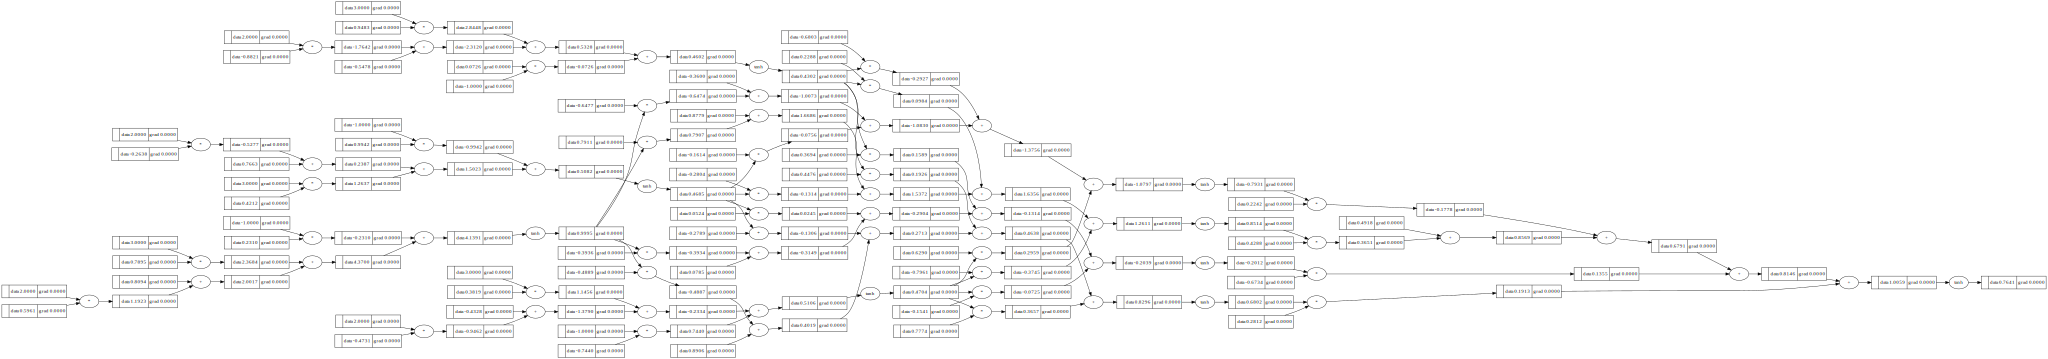

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0], # data sets
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # example target


In [ ]:
for k in range(20): # epochs = 10
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # MSE loss

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters(): # nudging weights and parameters
      p.data += -0.05 * p.grad # learning rate is 0.01





  print(k, loss.data)

0 0.0014494693857324333
1 0.0014449622540879292
2 0.0014404825921661053
3 0.001436030151518045
4 0.0014316046866684191
5 0.0014272059550712772
6 0.001422833717066573
7 0.0014184877358375929
8 0.0014141677773689143
9 0.0014098736104053017
10 0.0014056050064112848
11 0.001401361739531328
12 0.0013971435865508816
13 0.0013929503268579053
14 0.0013887817424052637
15 0.0013846376176735666
16 0.0013805177396348624
17 0.0013764218977167584
18 0.0013723498837673073
19 0.0013683014920203946


In [ ]:
ypred

[Value(data=0.9854080006460275),
 Value(data=-0.9802583555122045),
 Value(data=-0.9808683465349366),
 Value(data=0.9800094433423108)]

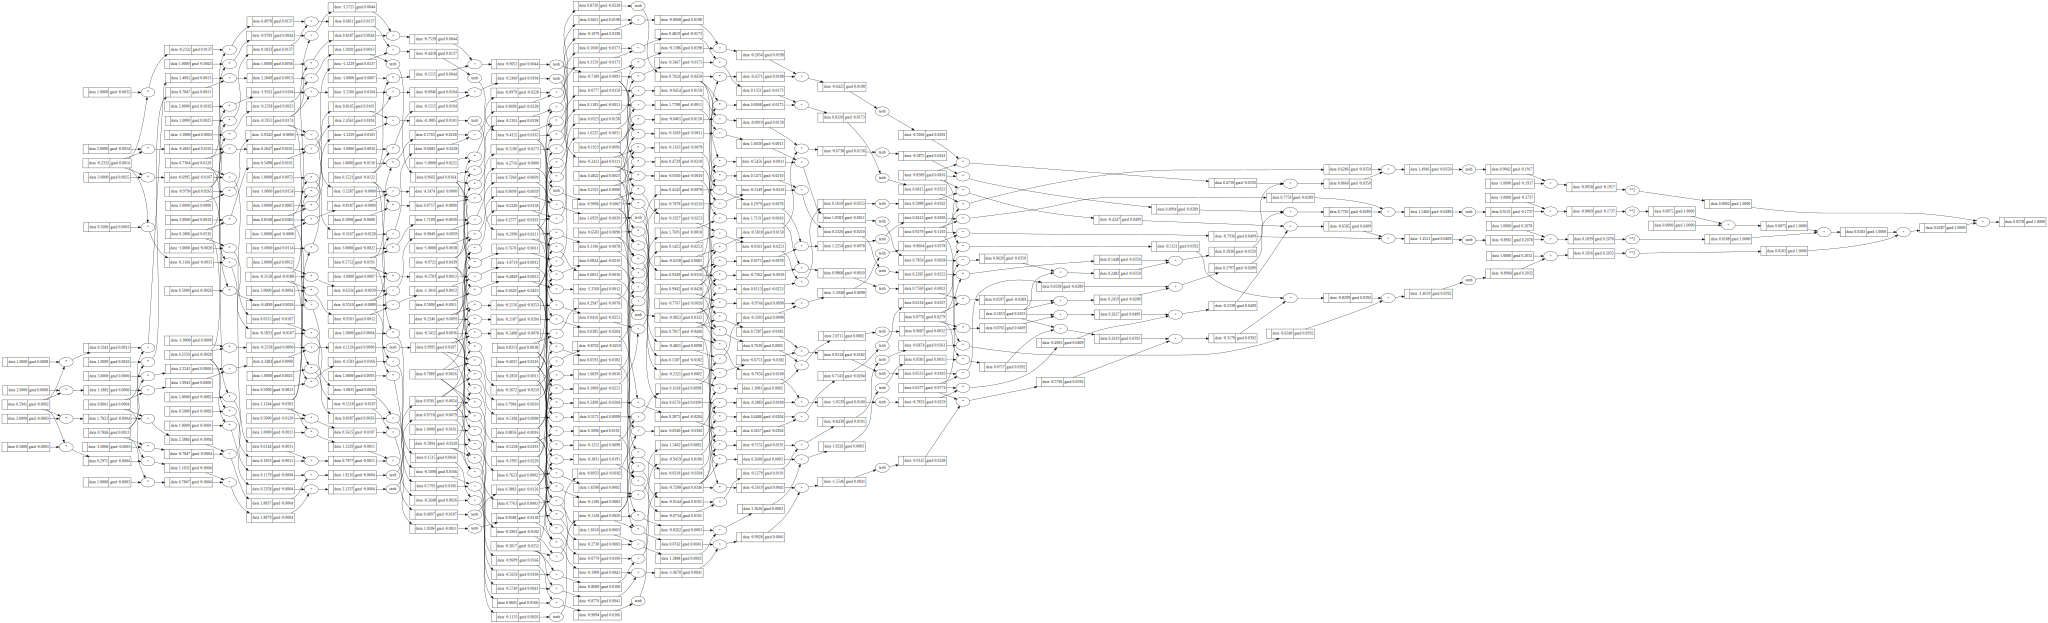

In [ ]:
draw_dot(loss)